In [1]:
import numpy as np
import pyuvdata
import matplotlib.pyplot as plt
import array_sensitivity
import importlib
importlib.reload(array_sensitivity)

<module 'array_sensitivity' from '/Users/ruby/Astro/PSsensitivity/array_sensitivity.py'>

In [2]:
# Set instrument parameters
antpos_filepath = "20210226W.cfg"
c = 3e8
min_freq_hz = 0.7e9
max_freq_hz = c / 0.21
freq_hz = np.mean([min_freq_hz, max_freq_hz])
tsys_k = 25
aperture_efficiency = 0.62
field_of_view_deg2 = 10.6
antenna_diameter_m = 5
freq_resolution_hz = 162.5e3
int_time_s = 15.0 * 60  # 15 minutes in each survey field
max_bl_m = 1000

In [3]:
antpos = array_sensitivity.get_antpos(antpos_filepath)

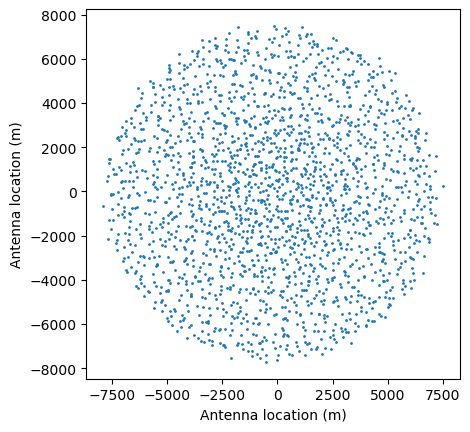

In [4]:
fig, ax = plt.subplots()
ax.scatter(antpos[:,0], antpos[:,1], s=1)
ax.set_aspect(1)
ax.set_xlabel("Antenna location (m)")
ax.set_ylabel("Antenna location (m)")
plt.show()

In [ ]:
baselines_m = array_sensitivity.get_baselines(antpos)
fig, ax = plt.subplots()
ax.scatter(baselines_m[:,0], baselines_m[:,1], s=1)
ax.set_aspect(1)
ax.set_xlabel("u (m)")
ax.set_ylabel("v (m)")
plt.show()

In [ ]:
plt.hist(np.sqrt(np.sum(baselines_m**2., axis=1)), bins=100)
plt.xlabel("baseline length (m)")
plt.ylabel("histogram count")
plt.show()

In [ ]:
# Define bin edges:
min_k = 0
max_k = 8.
n_kbins = 50
k_bin_size = (max_k - min_k) / n_kbins
bin_edges = np.linspace(min_k - k_bin_size / 2, max_k - k_bin_size / 2, num=n_kbins+1)

In [ ]:
(
    nsamples,
    binned_ps_variance,
    nsamples_2d,
    binned_ps_variance_2d,
) = array_sensitivity.delay_ps_sensitivity_analysis(
    antpos_filepath=antpos_filepath,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    tsys_k=tsys_k,
    aperture_efficiency=aperture_efficiency,
    antenna_diameter_m=antenna_diameter_m,
    freq_resolution_hz=freq_resolution_hz,
    int_time_s=int_time_s,
    max_bl_m=max_bl_m,
    k_bin_edges_1d=bin_edges,
    kpar_bin_edges=bin_edges,
    kperp_bin_edges=bin_edges,
    zenith_angle=0
)

In [ ]:
plt.scatter(bin_edges[:-1], np.sqrt(binned_ps_variance), s=1)

In [ ]:
# Load CAMB power spectrum data
f = open("camb_49591724_matterpower_z0.5.dat", "r")
file_data = f.readlines()
f.close()
model_k_axis = []
ps_model_unnorm = []
for line in file_data:
    model_k_axis.append(float(line.split()[0]))
    ps_model_unnorm.append(float(line.split()[1]))
ps_model = array_sensitivity.matter_ps_to_21cm_ps_conversion(
    np.array(model_k_axis),
    np.array(ps_model_unnorm),
    0.5
)

In [ ]:
plt.scatter(model_k_axis, ps_model_unnorm, s=1)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("k (h/Mpc)")
plt.ylabel("P (Mpc/h)^3")
plt.title("CAMB Theory")
plt.xlim([1e-2,1e0])
plt.show()

In [ ]:
plt.scatter(model_k_axis, ps_model, s=1)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("k (h/Mpc)")
plt.ylabel("P (mK)^2")
plt.title("CAMB Theory")
plt.xlim([1e-2,1e0])
plt.show()

In [ ]:
uv_extent = 4000
sample_variance_cube, bin_centers_sample_variance, binned_ps_sample_variance = array_sensitivity.get_sample_variance(
    ps_model,  # Units mK^2
    model_k_axis,  # Units h/Mpc
    uv_extent=uv_extent,
    field_of_view_deg2=field_of_view_deg2,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    freq_resolution_hz=freq_resolution_hz,
    k_bin_edges=bin_edges,
)

In [ ]:
u_coords_wl = np.arange(0,5)
v_coords_wl = np.arange(10,15)
print(u_coords_wl)
print(v_coords_wl)
u_coords_meshed, v_coords_meshed = np.meshgrid(u_coords_wl, v_coords_wl)
print(u_coords_meshed)
print(v_coords_meshed)

In [ ]:
uv_locs = np.stack((u_coords_meshed.flatten(), v_coords_meshed.flatten()), axis=-1)
print(np.shape(uv_locs))

In [ ]:
print(uv_locs)

In [ ]:
delay_array_s = np.arange(5,10,.5)
print(delay_array_s)
delay_array_lower_bounds = [
    np.mean([delay_array_s[ind], delay_array_s[ind + 1]])
    for ind in range(len(delay_array_s) - 1)
]
# Add the lower bound for the lowest delay bin
delay_array_lower_bounds = np.array(
    [delay_array_s[0] - (delay_array_s[1] - delay_array_s[0]) / 2]
    + delay_array_lower_bounds
)
print(delay_array_lower_bounds)